In [1]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

DATA_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/data'
MODEL_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/model'
VAL_TO_IDX_DATA_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Server/data'

In [2]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [3]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## 데이터셋 구축

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, 'clean_score.csv'))
df['problem_id'] = df['problem_id'].astype(int).astype(str)
df['target'] = df['target'].astype(int).astype(str)
df['key'] = df['user_name'] + '-' + df['target']

new_df = []

group_df = df.groupby('key')

for key, g_df in tqdm(group_df):
    new_df.append(g_df[~(g_df.duplicated('problem_id'))].copy())

new_df = pd.concat(new_df).reset_index(drop = True)

In [ ]:
len(new_df)

1486949

In [7]:
import json

with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'clean_problem_id_to_idx.json'), 'r', encoding = 'utf-8') as f:
    problemId_to_idx = json.load(f)

with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'clean_idx_to_problem_id.json'), 'r', encoding = 'utf-8') as f:
    idx_to_problemId = json.load(f)

In [9]:
def get_problemId2idx(x):
    if x in problemId_to_idx: return int(problemId_to_idx[x]) + 1
    else: return np.nan
    
def get_target2idx(x):
    if x in problemId_to_idx: return int(problemId_to_idx[x])
    else: return np.nan
    
new_df['problemId2idx'] = new_df['problem_id'].apply(lambda x : get_problemId2idx(x))
new_df = new_df[~(new_df['problemId2idx'].isna())].reset_index(drop = True)
new_df['problemId2idx'] = new_df['problemId2idx'].astype(int)

new_df['target2idx'] = new_df['target'].apply(lambda x : get_target2idx(x))
new_df = new_df[~(new_df['target2idx'].isna())].reset_index(drop = True)
new_df['target2idx'] = new_df['target2idx'].astype(int)

In [11]:
len(new_df)

1486949

## 데이터셋 분리

In [12]:
train_df = []
valid_df = []

group_df = new_df.groupby('target')
for target, g_df in tqdm(group_df):
    gg_df = g_df.groupby('key')
    for idx, (userID, ggg_df) in enumerate(gg_df):
        if idx == 0:
            valid_df.append(ggg_df)
        else:
            train_df.append(ggg_df)

100%|██████████| 6866/6866 [00:08<00:00, 844.28it/s] 


In [13]:
train_df = pd.concat(train_df).reset_index(drop = True)
valid_df = pd.concat(valid_df).reset_index(drop = True)

In [14]:
train_df.to_csv(os.path.join(DATA_PATH, 'clean_train_df.csv'), index = False)
valid_df.to_csv(os.path.join(DATA_PATH, 'clean_valid_df.csv'), index = False)

## 모델

In [4]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, Q, K, V, mask):
        """
        Q, K, V : (batch_size, num_heads, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        """
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units) # (batch_size, num_heads, max_len, max_len)
        attn_score = attn_score.masked_fill(mask == 0, -1e9)  # 유사도가 0인 지점은 -infinity로 보내 softmax 결과가 0이 되도록 함
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1))  # attention distribution
        output = torch.matmul(attn_dist, V)  # (batch_size, num_heads, max_len, hidden_units) / # dim of output : batchSize x num_head x seqLen x hidden_units
        return output, attn_dist


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # head의 수
        self.hidden_units = hidden_units
        
        # query, key, value, output 생성을 위해 Linear 모델 생성
        self.W_Q = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_O = nn.Linear(hidden_units, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate) # dropout rate
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, enc, mask):
        """
        enc : (batch_size, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        
        """
        residual = enc # residual connection을 위해 residual 부분을 저장
        batch_size, seqlen = enc.size(0), enc.size(1)

        # Query, Key, Value를 (num_head)개의 Head로 나누어 각기 다른 Linear projection을 통과시킴
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units // self.num_heads) # (batch_size, max_len, num_heads, hidden_units)
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units // self.num_heads) # (batch_size, max_len, num_heads, hidden_units)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units // self.num_heads) # (batch_size, max_len, num_heads, hidden_units)

        # Head별로 각기 다른 attention이 가능하도록 Transpose 후 각각 attention에 통과시킴
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2) # (batch_size, num_heads, max_len, hidden_units)
        output, attn_dist = self.attention(Q, K, V, mask) # output : (batch_size, num_heads, max_len, hidden_units) / attn_dist : (batch_size, num_heads, max_len, max_len)

        # 다시 Transpose한 후 모든 head들의 attention 결과를 합칩니다.
        output = output.transpose(1, 2).contiguous() # (batch_size, max_len, num_heads, hidden_units) / contiguous() : 가변적 메모리 할당
        output = output.view(batch_size, seqlen, -1) # (batch_size, max_len, hidden_units * num_heads)

        # Linear Projection, Dropout, Residual sum, and Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual) # (batch_size, max_len, hidden_units)
        return output, attn_dist


class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()

        self.W_1 = nn.Linear(hidden_units, hidden_units)
        self.W_2 = nn.Linear(hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.relu(self.dropout(self.W_1(x))))
        output = self.layerNorm(self.dropout(output) + residual)
        return output


class SASRecBlock(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(SASRecBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        """
        input_enc : (batch_size, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        """
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist


class SASRec(nn.Module):
    def __init__(
        self, 
        num_assessmentItemID,
        hidden_units,
        num_heads, 
        num_layers, 
        dropout_rate):
        super(SASRec, self).__init__()

        self.assessmentItemID_emb = nn.Embedding(num_assessmentItemID + 1, hidden_units, padding_idx = 0) # 문항에 대한 정보

        self.blocks = nn.ModuleList([SASRecBlock(num_heads, hidden_units, dropout_rate) for _ in range(num_layers)])

        self.lstm = nn.LSTM(
            input_size = hidden_units,
            hidden_size = hidden_units,
            num_layers = num_layers,
            batch_first = True,
            bidirectional = False,
            dropout = dropout_rate,
            )
        
        self.predict_layer = nn.Sequential(
            nn.Linear(hidden_units, num_assessmentItemID)
        )
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
    def forward(self, input):
        """
        assessmentItem : (batch_size, max_len)
        """
        assessmentItem = input['assessmentItem']

        # masking
        mask_pad = torch.BoolTensor(assessmentItem > 0).unsqueeze(1).unsqueeze(1) # (batch_size, 1, 1, max_len)
        mask_time = (1 - torch.triu(torch.ones((1, 1, assessmentItem.size(1), assessmentItem.size(1))), diagonal=1)).bool() # (batch_size, 1, max_len, max_len)
        mask = (mask_pad & mask_time).to(self.device) # (batch_size, 1, max_len, max_len)

        assessmentItem_emb = self.assessmentItemID_emb(assessmentItem.to(self.device))
        for block in self.blocks:
            assessmentItem_emb, attn_dist = block(assessmentItem_emb, mask)

        assessmentItem_emb, _ = self.lstm(assessmentItem_emb)
        
        output = self.predict_layer(assessmentItem_emb[:, -1])

        return output

In [5]:
class CustomDataset(Dataset):
    def __init__(self, df):

        self.features = []
        self.targets = []

        group_df = df.groupby('target')

        for target2idx, g_df in group_df:
            gg_df = g_df.groupby('key')
            for userID, ggg_df in gg_df:
                if len(ggg_df) >= 2:
                    self.features.append(ggg_df['problemId2idx'].tolist()[:-1])
                    self.targets.append(ggg_df['problemId2idx'].tolist()[-1] - 1)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target = self.targets[idx]
        return {
            'assessmentItem' : np.array(feature), 
            'target' : target,
            }


def pad_sequence(seq, max_len, padding_value = 0):
    try:
        seq_len, col = seq.shape
        padding = np.zeros((max_len - seq_len, col)) + padding_value
    except:
        seq_len = seq.shape[0]
        padding = np.zeros((max_len - seq_len, )) + padding_value

    padding_seq = np.concatenate([padding, seq])

    return padding_seq


def make_collate_fn(samples):
    max_len = 0
    for sample in samples:
        seq_len = sample['assessmentItem'].shape[0]
        if max_len < seq_len:
            max_len = seq_len
    
    features = []
    targets = []

    for sample in samples:
        features += [pad_sequence(sample['assessmentItem'], max_len = max_len, padding_value = 0)]
        targets += [sample['target']]

    return {
        'assessmentItem' : torch.tensor(features, dtype = torch.long), 
        'target': torch.tensor(targets, dtype = torch.long),
    }

In [6]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(len(true_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

def get_rank(pred_list, true_list):
    ret_rank = len(pred_list) + 1
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            ret_rank = rank + 1
    return 0 if ret_rank == (len(pred_list) + 1) else ret_rank

def train(model, data_loader, criterion, optimizer):
    model.train()
    loss_val = 0

    for input in data_loader:

        optimizer.zero_grad()

        output = model(input)
        loss = criterion(output, input['target'].to(device))

        loss.backward()
        optimizer.step()

        loss_val += loss.item()

    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, data_loader, topk = 10):
    model.eval()

    hit = 0
    ndcg = 0
    rank = 0

    with torch.no_grad():
        for input in data_loader:
            
            output = -model(input)
            predictions = output.argsort()

            targets = input['target']

            for target, prediction in zip(targets, predictions):
                target = [target.item()]
                prediction = prediction.cpu().tolist()[:topk]

                hit += get_hit(prediction, target)
                ndcg += get_ndcg(prediction, target)
                rank += get_rank(prediction, target)
    
    rank = rank / hit
    hit = hit / len(data_loader.dataset)
    ndcg = ndcg / len(data_loader.dataset)

    return hit, ndcg, rank

## 학습

In [7]:
import json

with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'clean_problem_id_to_idx.json'), 'r', encoding = 'utf-8') as f:
    problemId_to_idx = json.load(f)

with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'clean_idx_to_problem_id.json'), 'r', encoding = 'utf-8') as f:
    idx_to_problemId = json.load(f)

In [8]:
batch_size = 512
epochs = 20
lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

hidden_units = 128
num_heads = 8
num_layers = 1
dropout_rate = 0.5
num_workers = 8
num_assessmentItemID = len(problemId_to_idx)

model_name = 'clean-User-Seq-Transformer'

In [9]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'clean_train_df.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'clean_valid_df.csv'))

In [10]:
seed_everything(22)

In [11]:
train_dataset = CustomDataset(df = train_df)
train_data_loader = DataLoader(
        train_dataset, 
        batch_size = batch_size, 
        shuffle = True, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = num_workers)


valid_dataset = CustomDataset(df = valid_df)
valid_data_loader = DataLoader(
        valid_dataset, 
        batch_size = batch_size, 
        shuffle = False, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = num_workers)

In [11]:
model = SASRec(
        num_assessmentItemID = num_assessmentItemID,
        hidden_units = hidden_units,
        num_heads = num_heads,
        num_layers = num_layers,
        dropout_rate = dropout_rate
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [13]:
best_ndcg = 0

for epoch in range(1, epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
            train_loss = train(model = model, data_loader = train_data_loader, criterion = criterion, optimizer = optimizer)
            hit, ndcg, rank = evaluate(model = model, data_loader = valid_data_loader)
            if best_ndcg < ndcg:
                best_epoch = epoch
                best_train_loss = train_loss
                best_ndcg = ndcg
                best_hit = hit
                best_rank = rank
                torch.save(model.state_dict(), os.path.join(MODEL_PATH, model_name + '.pt'))

            tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}| Rank@10: {rank:.5f}')
    
print(f'BEST | Epoch: {best_epoch:3d}| Train loss: {best_train_loss:.5f}| NDCG@10: {best_ndcg:.5f}| HIT@10: {best_hit:.5f}| Rank@10: {best_rank:.5f}')

Epoch:   1| Train loss: 8.80483| NDCG@10: 0.02161| HIT@10: 0.02980| Rank@10: 2.70936: 100%|██████████| 1/1 [00:09<00:00,  9.57s/it]
Epoch:   2| Train loss: 8.38384| NDCG@10: 0.05263| HIT@10: 0.07735| Rank@10: 3.21252: 100%|██████████| 1/1 [00:08<00:00,  8.86s/it]
Epoch:   3| Train loss: 7.64891| NDCG@10: 0.07629| HIT@10: 0.10818| Rank@10: 2.90366: 100%|██████████| 1/1 [00:08<00:00,  9.00s/it]
Epoch:   4| Train loss: 7.04037| NDCG@10: 0.09601| HIT@10: 0.13239| Rank@10: 2.82483: 100%|██████████| 1/1 [00:08<00:00,  8.87s/it]
Epoch:   5| Train loss: 6.55012| NDCG@10: 0.10734| HIT@10: 0.14634| Rank@10: 2.74423: 100%|██████████| 1/1 [00:08<00:00,  8.82s/it]
Epoch:   6| Train loss: 6.13076| NDCG@10: 0.11711| HIT@10: 0.15676| Rank@10: 2.66105: 100%|██████████| 1/1 [00:08<00:00,  8.97s/it]
Epoch:   7| Train loss: 5.76179| NDCG@10: 0.12300| HIT@10: 0.16527| Rank@10: 2.62522: 100%|██████████| 1/1 [00:08<00:00,  8.56s/it]
Epoch:   8| Train loss: 5.42871| NDCG@10: 0.12808| HIT@10: 0.17070| Rank@10:

BEST | Epoch:  15| Train loss: 3.71093| NDCG@10: 0.14016| HIT@10: 0.18391| Rank@10: 2.50998


```
Epoch:   1| Train loss: 8.80483| NDCG@10: 0.02161| HIT@10: 0.02980| Rank@10: 2.70936: 100%|██████████| 1/1 [00:08<00:00,  8.94s/it]
Epoch:   2| Train loss: 8.38381| NDCG@10: 0.05243| HIT@10: 0.07706| Rank@10: 3.19619: 100%|██████████| 1/1 [00:08<00:00,  8.41s/it]
Epoch:   3| Train loss: 7.64885| NDCG@10: 0.07625| HIT@10: 0.10818| Rank@10: 2.90366: 100%|██████████| 1/1 [00:08<00:00,  8.38s/it]
Epoch:   4| Train loss: 7.04034| NDCG@10: 0.09540| HIT@10: 0.13093| Rank@10: 2.74103: 100%|██████████| 1/1 [00:08<00:00,  8.34s/it]
Epoch:   5| Train loss: 6.55008| NDCG@10: 0.10707| HIT@10: 0.14458| Rank@10: 2.65178: 100%|██████████| 1/1 [00:08<00:00,  8.42s/it]
Epoch:   6| Train loss: 6.13037| NDCG@10: 0.11682| HIT@10: 0.15632| Rank@10: 2.62723: 100%|██████████| 1/1 [00:08<00:00,  8.46s/it]
Epoch:   7| Train loss: 5.76239| NDCG@10: 0.12359| HIT@10: 0.16513| Rank@10: 2.62222: 100%|██████████| 1/1 [00:08<00:00,  8.33s/it]
Epoch:   8| Train loss: 5.42821| NDCG@10: 0.12860| HIT@10: 0.17129| Rank@10: 2.60583: 100%|██████████| 1/1 [00:08<00:00,  8.55s/it]
Epoch:   9| Train loss: 5.12817| NDCG@10: 0.12910| HIT@10: 0.17158| Rank@10: 2.50128: 100%|██████████| 1/1 [00:08<00:00,  8.09s/it]
Epoch:  10| Train loss: 4.84865| NDCG@10: 0.13466| HIT@10: 0.17907| Rank@10: 2.59590: 100%|██████████| 1/1 [00:08<00:00,  8.48s/it]
Epoch:  11| Train loss: 4.59148| NDCG@10: 0.13501| HIT@10: 0.17716| Rank@10: 2.47142: 100%|██████████| 1/1 [00:08<00:00,  8.45s/it]
Epoch:  12| Train loss: 4.34668| NDCG@10: 0.13762| HIT@10: 0.18186| Rank@10: 2.48749: 100%|██████████| 1/1 [00:08<00:00,  8.31s/it]
Epoch:  13| Train loss: 4.12242| NDCG@10: 0.13800| HIT@10: 0.18200| Rank@10: 2.53952: 100%|██████████| 1/1 [00:08<00:00,  8.52s/it]
Epoch:  14| Train loss: 3.90938| NDCG@10: 0.13800| HIT@10: 0.18303| Rank@10: 2.57899: 100%|██████████| 1/1 [00:08<00:00,  8.68s/it]
Epoch:  15| Train loss: 3.70974| NDCG@10: 0.13831| HIT@10: 0.18245| Rank@10: 2.50603: 100%|██████████| 1/1 [00:08<00:00,  8.50s/it]
Epoch:  16| Train loss: 3.51845| NDCG@10: 0.13719| HIT@10: 0.18010| Rank@10: 2.48900: 100%|██████████| 1/1 [00:08<00:00,  8.29s/it]
Epoch:  17| Train loss: 3.33878| NDCG@10: 0.13784| HIT@10: 0.17980| Rank@10: 2.43837: 100%|██████████| 1/1 [00:08<00:00,  8.27s/it]
Epoch:  18| Train loss: 3.16704| NDCG@10: 0.13596| HIT@10: 0.17834| Rank@10: 2.50123: 100%|██████████| 1/1 [00:08<00:00,  8.48s/it]
Epoch:  19| Train loss: 3.00685| NDCG@10: 0.13749| HIT@10: 0.18112| Rank@10: 2.54862: 100%|██████████| 1/1 [00:08<00:00,  8.28s/it]
Epoch:  20| Train loss: 2.85094| NDCG@10: 0.13580| HIT@10: 0.17848| Rank@10: 2.54030: 100%|██████████| 1/1 [00:08<00:00,  8.70s/it]

```

In [12]:
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, model_name + '.pt')))

<All keys matched successfully>

In [20]:
vectors = model.assessmentItemID_emb.weight.detach().cpu().numpy()[1:, :]

In [ ]:
import pickle

EMBEDDING_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/embedding'

with open(os.path.join(EMBEDDING_PATH, 'Seq-Embedding.pickle'), 'wb') as file:
    pickle.dump(vectors, file, protocol = 4)

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
tsne_vectors = tsne.fit_transform(vectors)

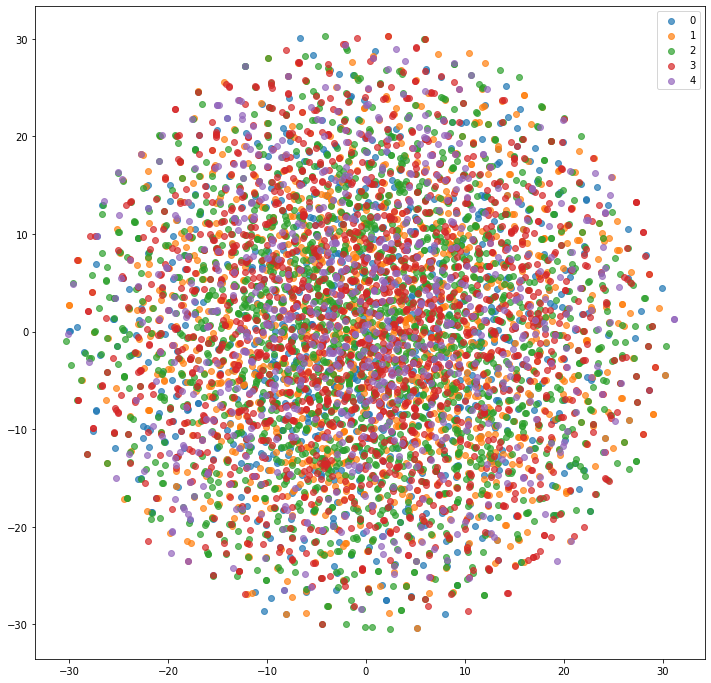

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))

problem_df = pd.read_csv(os.path.join(DATA_PATH, 'clean_problem.csv'))
problem_df['problem_id'] = problem_df['problem_id'].astype(str)
problem_df['problem_id2idx'] = problem_df['problem_id'].apply(lambda x : int(problemId_to_idx[x]))
problem_df['level_tag'] = problem_df['level'].apply(lambda x : (x - 1) // 5)

for level_tag in sorted(problem_df['level_tag'].unique()):
    idx = problem_df[problem_df['level_tag'] == level_tag]['problem_id2idx'].tolist()
    plt.scatter(x = tsne_vectors[idx, 0], y = tsne_vectors[idx, 1], alpha = 0.7, label = f'{level_tag}') 

plt.legend()
plt.show()